# Customer Churn Prevention
by Stefanie Müller

Data source: https://www.kaggle.com/blastchar/telco-customer-churn


1. Revealing the important characteristics of customers who canceled their contracts by calculating the correlations with this variable.
    - Correlations are seen after Cohen, 1988 (Pearson-Correlationcoefficient)
        - 0.1 = small
        - 0.3 = moderate
        - 0.5 = strong
2. Creating a classifier to identify critical customers. This classifier can identify customers who have canceled based on their characteristics. Also it can be used to show which customer should be looked into their contract details because there are critical conditions which could lead them to wander off. This will be done by looking into the actually active customer who were classified as former ones.

3. Clustering of the critical customers by their contract values to prioritize the inspection.
4. Saving customers to check to csv.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
#Importing data
customer_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
customer_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
#Checked all columns manually
customer_data["PaymentMethod"].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [4]:
#Overview and checking for NA
display(customer_data.dtypes, pd.isna(customer_data).sum())

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
#Replacing binary values
customer_data["Churn"] = customer_data["Churn"].map({'Yes': 1, 'No': 0})
customer_data["PaperlessBilling"] = customer_data["PaperlessBilling"].map({'Yes': 1, 'No': 0})
customer_data["PhoneService"] = customer_data["PhoneService"].map({'Yes': 1, 'No': 0})
customer_data["Dependents"] = customer_data["Dependents"].map({'Yes': 1, 'No': 0})
customer_data["Partner"] = customer_data["Partner"].map({'Yes': 1, 'No': 0})
customer_data["gender"] = customer_data["gender"].map({'Female': 1, 'Male': 0})

#Replacing space in TotalCharges with 0
customer_data["TotalCharges"] = customer_data['TotalCharges'].apply(lambda x: '0' if ' ' in x else x)

#Converting to numeric
customer_data["TotalCharges"] = pd.to_numeric(customer_data["TotalCharges"], errors='coerce')
customer_data["MonthlyCharges"] = pd.to_numeric(customer_data["MonthlyCharges"])
customer_data["tenure"] = pd.to_numeric(customer_data["tenure"])

#Todo functions
#create dummie variables for categorical columns
#"No internet service" is a redundant column value -> will only be kept once
extr_MultipleLines = pd.get_dummies(customer_data["MultipleLines"])
customer_data = pd.concat([customer_data, extr_MultipleLines], axis=1)
customer_data.rename({'No' : 'MultipleLines_No', 'Yes' : 'MultipleLines_Yes', 'No phone service': 'MultipleLines_nps'}, axis=1, inplace=True)
customer_data = customer_data.drop(["MultipleLines"], axis=1)

extr_InternetService = pd.get_dummies(customer_data["InternetService"])
customer_data = pd.concat([customer_data, extr_InternetService], axis=1)
customer_data.rename({'No' : 'InternetService_No', 'DSL' : 'InternetService_DSL', 'Fiber optic': 'InternetService_Fib'}, axis=1, inplace=True)
customer_data = customer_data.drop(["InternetService"], axis=1)

extr_OnlineSecurity = pd.get_dummies(customer_data["OnlineSecurity"])
customer_data = pd.concat([customer_data, extr_OnlineSecurity], axis=1)
customer_data.rename({'No' : 'OnlineSecurity_No', 'Yes' : 'OnlineSecurity_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["OnlineSecurity", "No internet service"], axis=1)

extr_OnlineBackup = pd.get_dummies(customer_data["OnlineBackup"])
customer_data = pd.concat([customer_data, extr_OnlineBackup], axis=1)
customer_data.rename({'No' : 'OnlineBackup_No', 'Yes' : 'OnlineBackup_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["OnlineBackup", "No internet service"], axis=1)

extr_DeviceProtection = pd.get_dummies(customer_data["DeviceProtection"])
customer_data = pd.concat([customer_data, extr_DeviceProtection], axis=1)
customer_data.rename({'No' : 'DeviceProtection_No', 'Yes' : 'DeviceProtection_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["DeviceProtection", "No internet service"], axis=1)

extr_TechSupport = pd.get_dummies(customer_data["TechSupport"])
customer_data = pd.concat([customer_data, extr_TechSupport], axis=1)
customer_data.rename({'No' : 'TechSupport_No', 'Yes' : 'TechSupport_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["TechSupport", "No internet service"], axis=1)

extr_StreamingTV = pd.get_dummies(customer_data["StreamingTV"])
customer_data = pd.concat([customer_data, extr_StreamingTV], axis=1)
customer_data.rename({'No' : 'StreamingTV_No', 'Yes' : 'StreamingTV_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["StreamingTV", "No internet service"], axis=1)

extr_StreamingMovies = pd.get_dummies(customer_data["StreamingMovies"])
customer_data = pd.concat([customer_data, extr_StreamingMovies], axis=1)
customer_data.rename({'No' : 'StreamingMovies_No', 'Yes' : 'StreamingMovies_Yes'}, axis=1, inplace=True)
customer_data = customer_data.drop(["StreamingMovies", "No internet service"], axis=1)

extr_Contract = pd.get_dummies(customer_data["Contract"])
customer_data = pd.concat([customer_data, extr_Contract], axis=1)
customer_data = customer_data.drop(["Contract"], axis=1)

extr_PaymentMethod = pd.get_dummies(customer_data["PaymentMethod"])
customer_data = pd.concat([customer_data, extr_PaymentMethod], axis=1)
customer_data = customer_data.drop(["PaymentMethod"], axis=1)

#active customer column
customer_data["Is_Active_Customer"] = customer_data["Churn"].map({1: 0, 0: 1})

In [6]:
customer_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_Yes,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Is_Active_Customer
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,1,0,1,0,0,0,0,1,0,1
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,1,0,0,0,0,1,1
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1,0,1,0,0,0,0,0,1,0
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,1,0,1,0,0,0,1
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,84.80,1990.50,...,0,1,0,1,0,0,0,0,1,1
7039,2234-XADUH,1,0,1,1,72,1,1,103.20,7362.90,...,0,1,0,1,0,0,1,0,0,1
7040,4801-JZAZL,1,0,1,1,11,0,1,29.60,346.45,...,1,0,1,0,0,0,0,1,0,1
7041,8361-LTMKD,0,1,1,0,4,1,1,74.40,306.60,...,1,0,1,0,0,0,0,0,1,0


# Graphical overview of the important variables

In [7]:
customer_data.dtypes

customerID                    object
gender                         int64
SeniorCitizen                  int64
Partner                        int64
Dependents                     int64
tenure                         int64
PhoneService                   int64
PaperlessBilling               int64
MonthlyCharges               float64
TotalCharges                 float64
Churn                          int64
MultipleLines_No               uint8
MultipleLines_nps              uint8
MultipleLines_Yes              uint8
InternetService_DSL            uint8
InternetService_Fib            uint8
InternetService_No             uint8
OnlineSecurity_No              uint8
OnlineSecurity_Yes             uint8
OnlineBackup_No                uint8
OnlineBackup_Yes               uint8
DeviceProtection_No            uint8
DeviceProtection_Yes           uint8
TechSupport_No                 uint8
TechSupport_Yes                uint8
StreamingTV_No                 uint8
StreamingTV_Yes                uint8
S

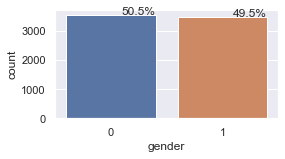

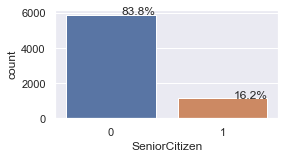

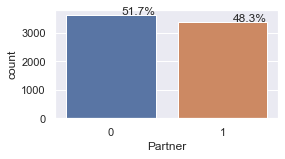

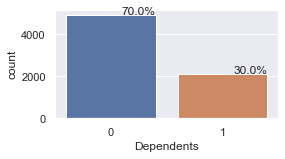

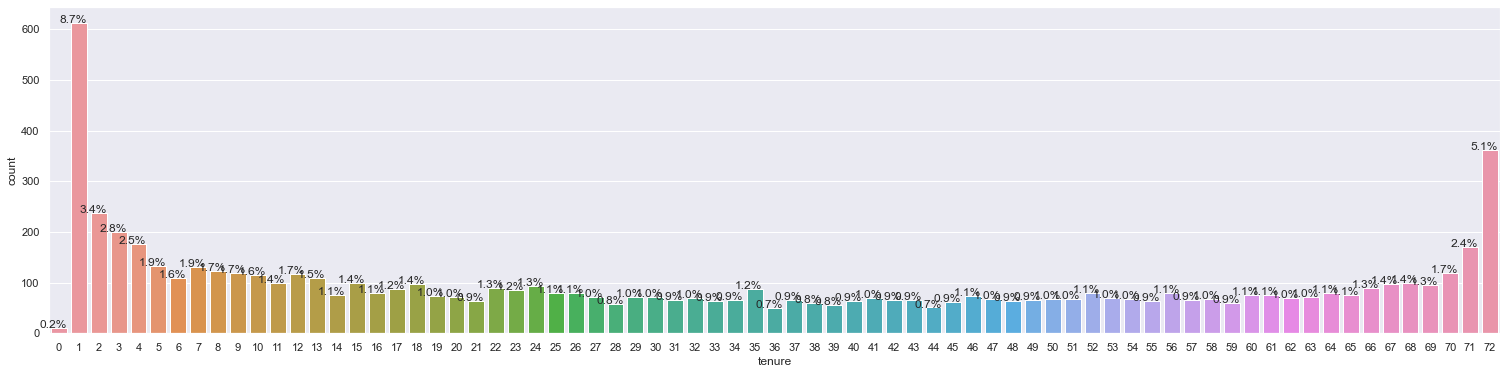

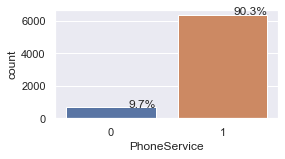

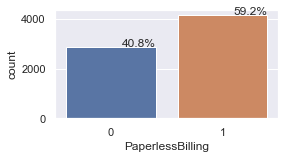

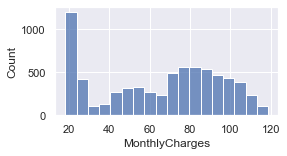

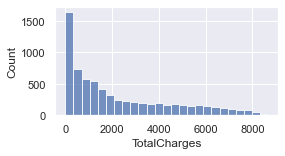

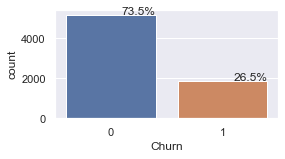

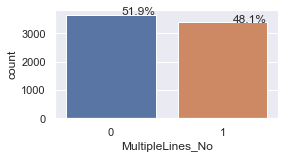

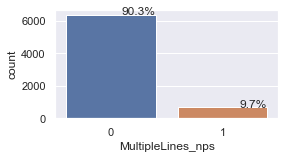

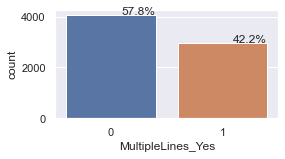

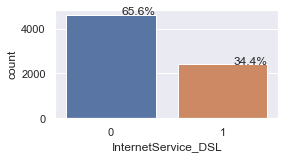

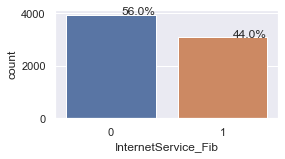

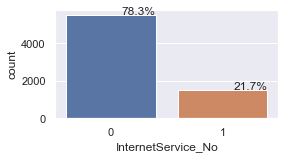

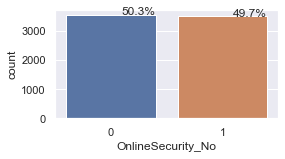

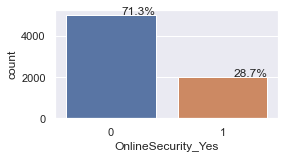

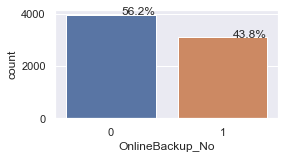

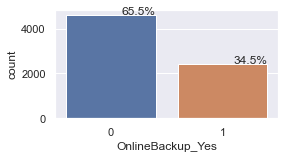

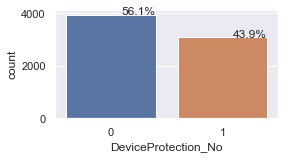

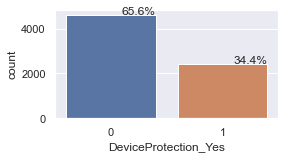

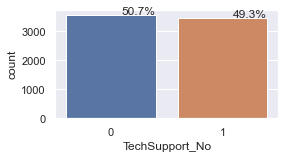

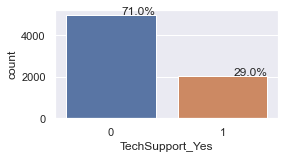

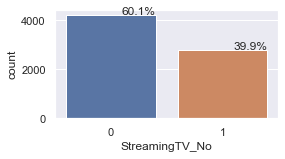

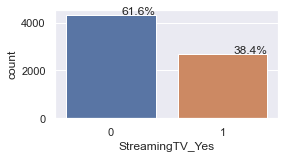

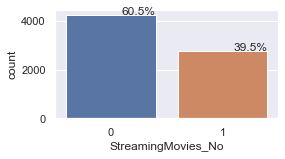

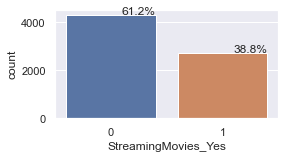

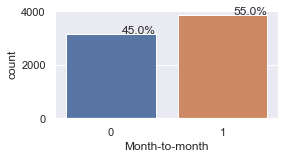

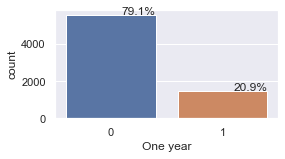

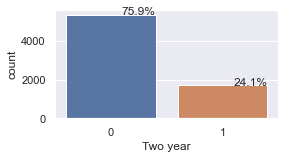

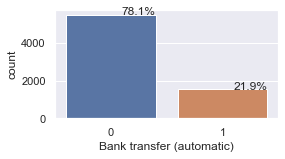

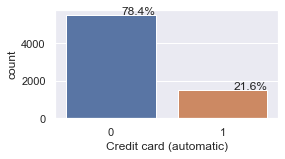

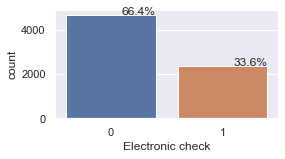

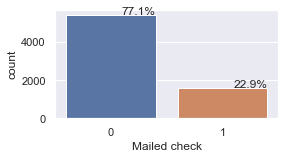

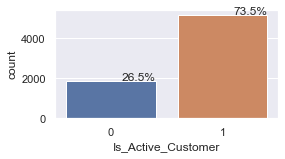

In [8]:
#Easy way to get an overview with plots
def adding_percentages(total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='right')

for col in customer_data.columns:
    if customer_data[col].dtypes == 'float64':
        sns.set(rc={'figure.figsize':(4,2)})
        sns.histplot(data=customer_data, x=col)

        plt.show()

    elif (customer_data[col].dtypes == 'int64' or customer_data[col].dtypes == 'int32' or customer_data[col].dtypes == 'uint8') and customer_data[col] is not customer_data["tenure"]:
        sns.set(rc={'figure.figsize':(4,2)})
        ax = sns.countplot(data=customer_data, x=col)

        adding_percentages(len(customer_data))

        plt.show()

    elif customer_data[col] is customer_data["tenure"]:
        sns.set(rc={'figure.figsize':(26,6)})
        ax = sns.countplot(data=customer_data, x=col)

        adding_percentages(len(customer_data))

        plt.show()

# Correlations only for Active Customers:

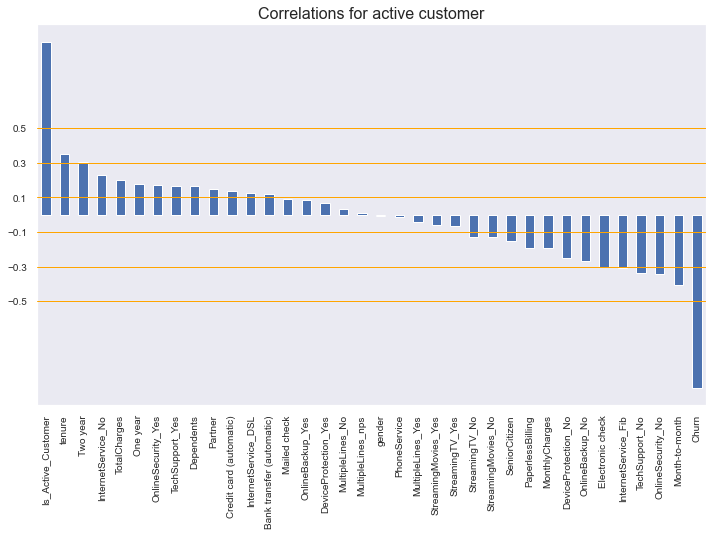

<Figure size 288x144 with 0 Axes>

In [9]:
#Correlation Overview for Active Customers:
fig, ax1 = plt.subplots()
ax1.set_axisbelow(False)
plt.title("Correlations for active customer", fontsize=16)
customer_data.corr()['Is_Active_Customer'].sort_values(ascending = False).plot(figsize=(12,7), ax=ax1, fontsize=10, kind='bar', yticks=[-0.5, -0.3, -0.1, 0.1, 0.3, 0.5], grid=False).grid(axis="y", color="orange")

plt.show()
plt.clf()

The following correlations should be considered when investigating customers to make them stay active ones:

    - Positive correlations::
        - above 0.3 = moderate:
            - tenure
            - Two year contracts
        - above 0.1 = small:
            - InternetService_No
            - TotalCharges
            - One Year contracts
            - OnlineSecurity_Yes
            - TechSupport_Yes
            - Dependants
            - Partner
            - Credit card (automatic)
            - InternetService_DSL
            - Bank transfer (automatic)

    - Negative correlations:
        - under -0.3 = moderate:
            - Month-to-month
            - OnlineSecurity_No
            - TechSupport_No
            - InternetService_Fib
            - Electronic check
        - under -0.1 = small:
            - OnlineBackup_No
            - DeviceProtection_No
            - MonthlyCharges
            - PaperlessBilling
            - SeniorCitizen
            - StreamingMovies_No
            - StreamingTV_No

### Correlations of all Variables to investigate dependencies in the other variables:
This will be only done by a simple example for this work.

In [10]:
#Function to create corr matrix
def create_corr_heatmap(data, title):
    #Calculating correlations
    corr_matrix = data.corr()

    #Hiding doubled half of the matrix:
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    color_palette = sns.color_palette("coolwarm_r", as_cmap=True)
    sns.set(font_scale=2.8)
    plt.subplots(figsize=(50,50))
    plt.title(title, fontsize=16)

    sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, annot_kws={"fontsize":20},  linewidths=0.1, cmap = color_palette, vmin=-1, vmax=1, mask = mask, fmt='.2f')
    plt.clf

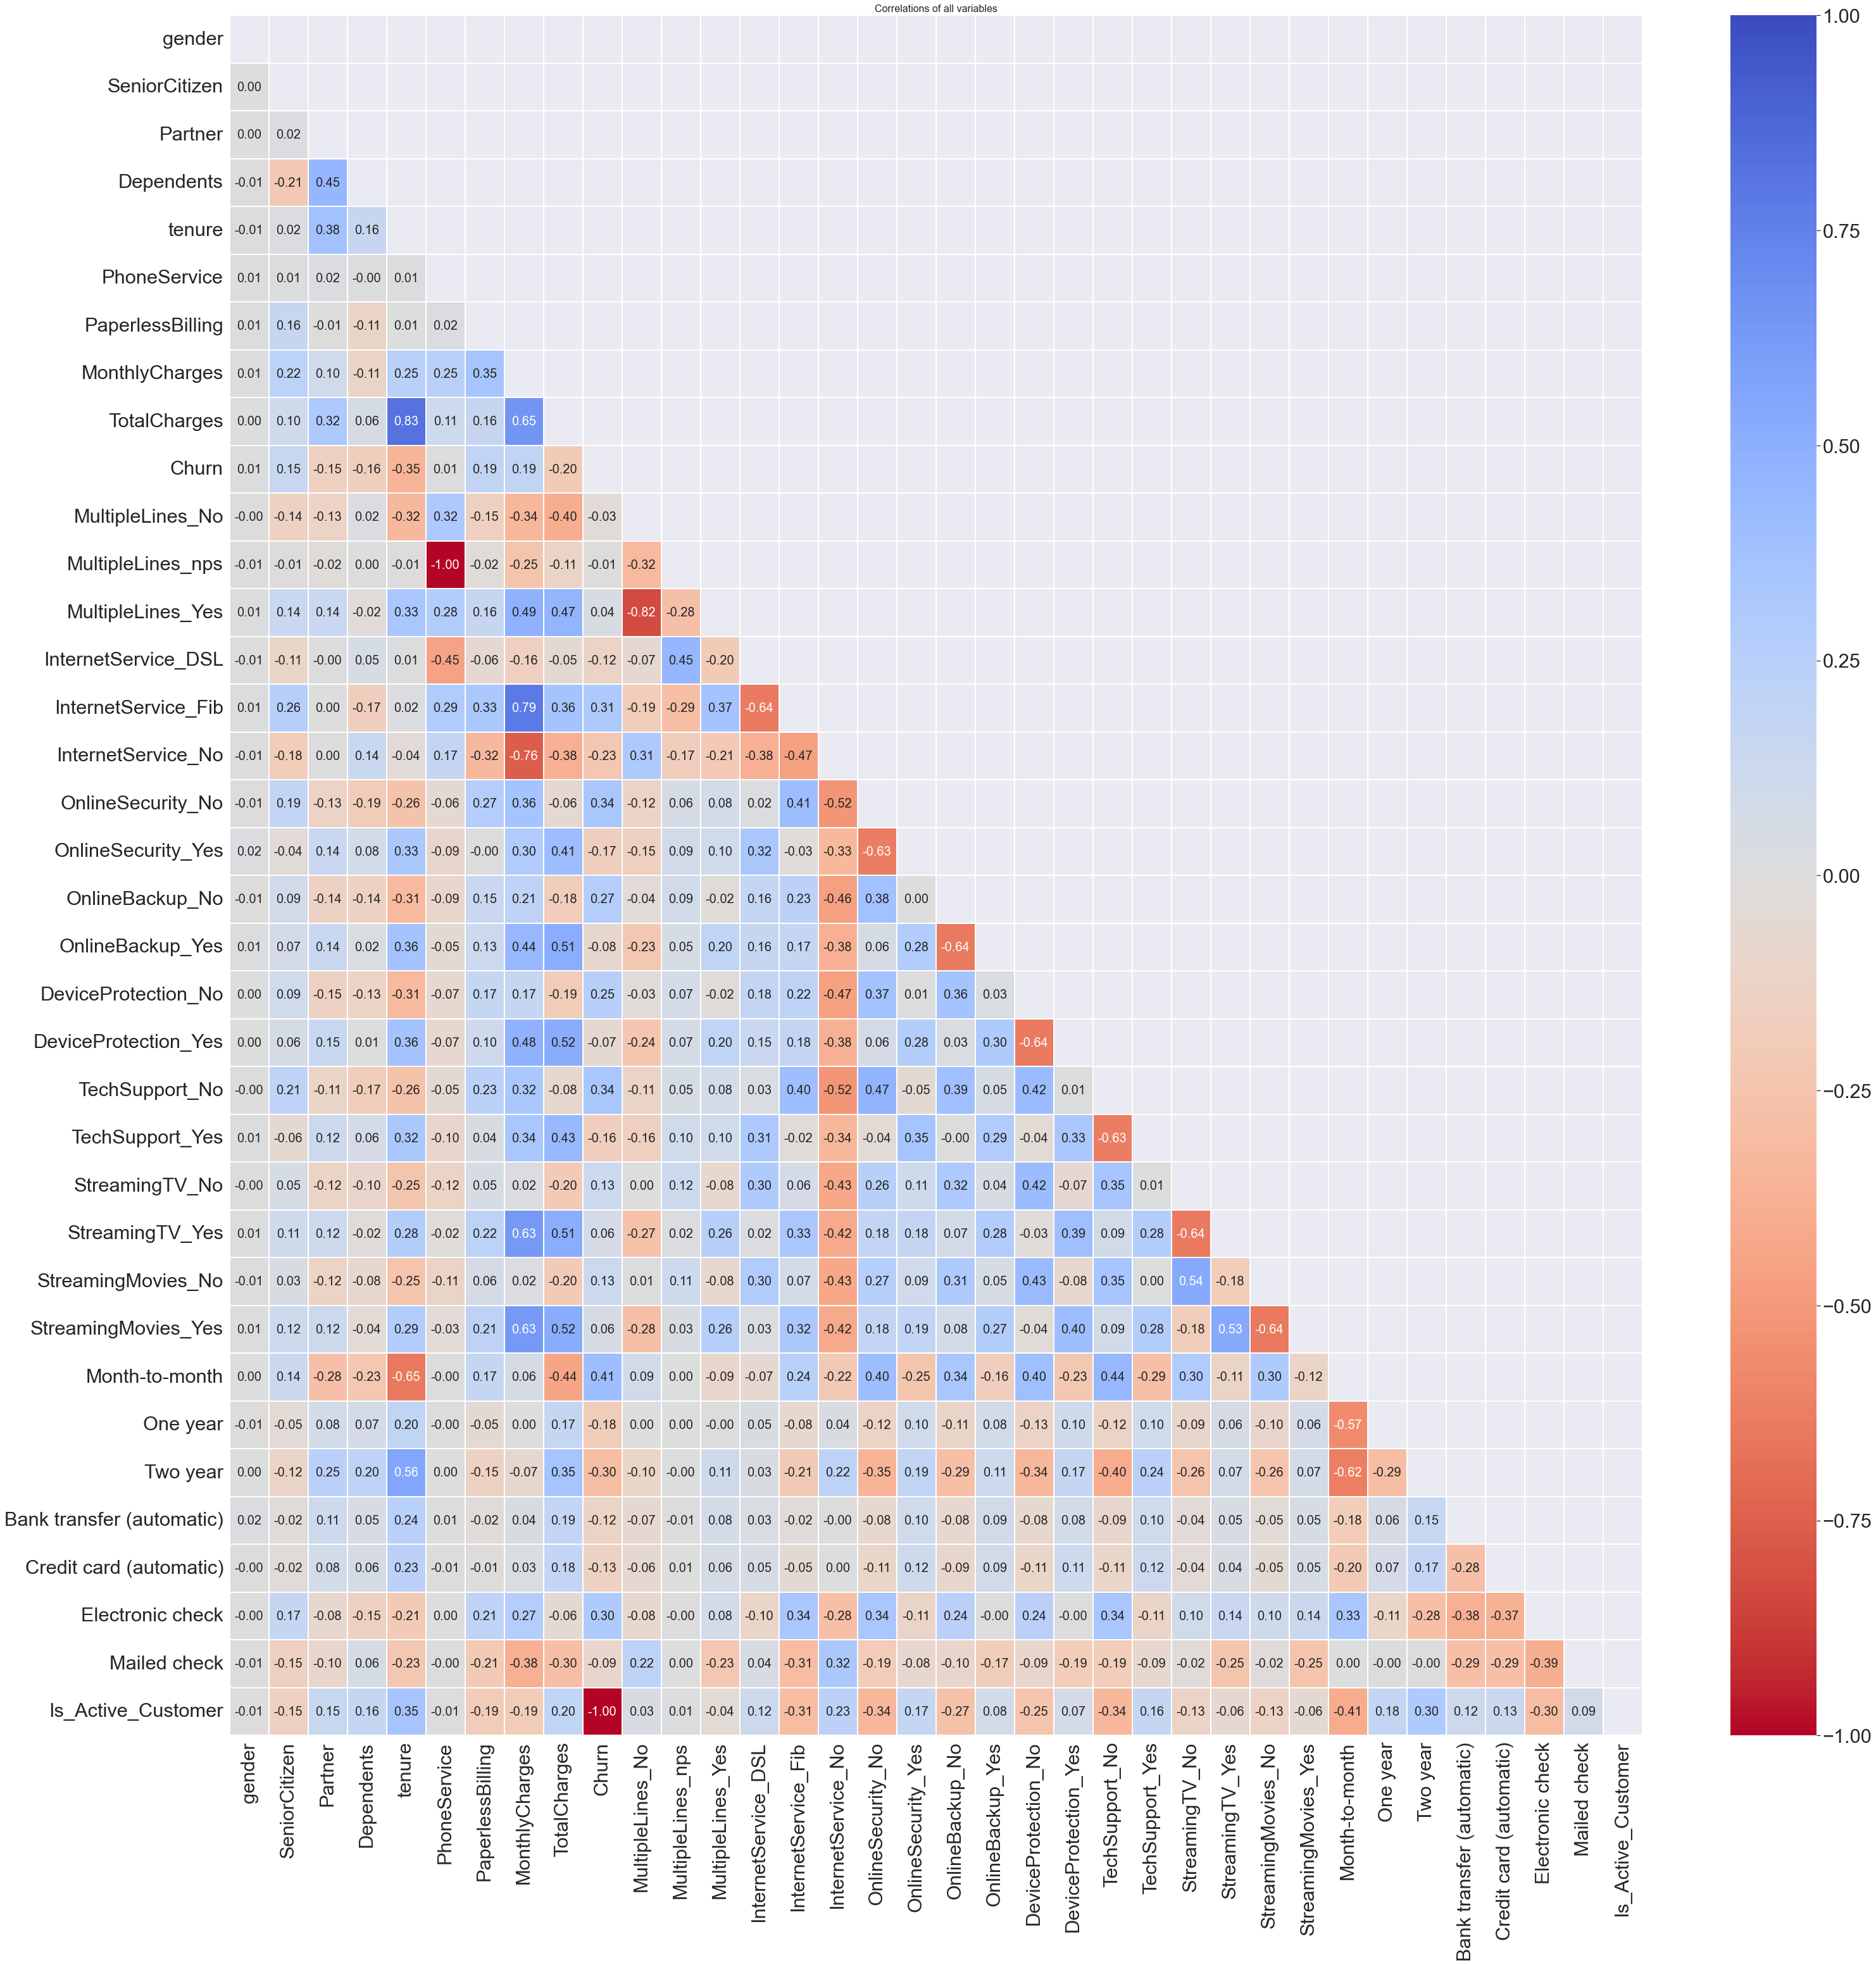

In [11]:
create_corr_heatmap(customer_data, "Correlations of all variables")

Inspecting correlations for all variables helps to understand the data in more detail. For example tenure is strongly negative correlated with month-to-month contracts and strongly correlated with Two years contracts. All three of them correlate in a similar way with active users, but now we can varify that tenure is indeed related to long term contracts. This leads to the conclusion that we should rather prefer to look into contract running types instead of tenure to initiate further actions.

This should be done for the other variables too.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [13]:
#Copy data and removing customerID
classifier_data = customer_data.copy()
classifier_data = classifier_data.drop(["customerID"], axis=1)
classifier_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_Yes,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Is_Active_Customer
0,1,0,1,0,1,0,1,29.85,29.85,0,...,1,0,1,0,0,0,0,1,0,1
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,1,0,0,0,0,1,1
2,0,0,0,0,2,1,1,53.85,108.15,1,...,1,0,1,0,0,0,0,0,1,0
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,1,0,1,0,0,0,1
4,1,0,0,0,2,1,1,70.70,151.65,1,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,84.80,1990.50,0,...,0,1,0,1,0,0,0,0,1,1
7039,1,0,1,1,72,1,1,103.20,7362.90,0,...,0,1,0,1,0,0,1,0,0,1
7040,1,0,1,1,11,0,1,29.60,346.45,0,...,1,0,1,0,0,0,0,1,0,1
7041,0,1,1,0,4,1,1,74.40,306.60,1,...,1,0,1,0,0,0,0,0,1,0


In [14]:
#Saving numerical columns
numerical_cols = ["TotalCharges", "MonthlyCharges", "tenure"]

In [15]:
#X and y
X = classifier_data.drop(["Churn", "Is_Active_Customer"], axis=1)
y = classifier_data["Is_Active_Customer"]

In [16]:
#Train-Test-Split for classifier training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,0,1,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,56.95,1889.50,1,...,0,1,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,1,53.85,108.15,1,...,0,1,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,0,1,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,84.80,1990.50,0,...,1,0,1,0,1,0,0,0,0,1
7039,1,0,1,1,72,1,1,103.20,7362.90,0,...,1,0,1,0,1,0,0,1,0,0
7040,1,0,1,1,11,0,1,29.60,346.45,0,...,0,1,0,1,0,0,0,0,1,0
7041,0,1,1,0,4,1,1,74.40,306.60,0,...,0,1,0,1,0,0,0,0,0,1


In [18]:
#Standardscaler for numerical columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols)])

prepped_X_train = preprocessor.fit_transform(X_train)
prepped_X_test = preprocessor.transform(X_test)

In [19]:
model = LogisticRegression(solver='lbfgs', max_iter=200)
result = model.fit(prepped_X_train, y_train)
pred_test = model.predict(prepped_X_test)

# Print the prediction accuracy
print (f"Logistic Regression Accuracy: {round(metrics.accuracy_score(y_test, pred_test)*100, 2)} %")

Logistic Regression Accuracy: 77.71 %


It is adviced to try several classifier to find the one with the highest accuracy on this dataset. Additionally the model should then be saved.

In [20]:
#Using model on all data to decide critical customers
prepped_X = preprocessor.fit_transform(X)
pred_X = model.predict(prepped_X)

In [21]:
#Adding column with prediction result
customer_data['ActiveCustomer_pred'] = np.round(pred_X).astype(int)
customer_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_Yes,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Is_Active_Customer,ActiveCustomer_pred
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,0,1,0,0,0,0,1,0,1,1
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,0,0,1,0,0,0,0,1,1,1
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,0,1,0,0,0,0,0,1,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0,0,1,0,1,0,0,0,1,1
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,84.80,1990.50,...,1,0,1,0,0,0,0,1,1,1
7039,2234-XADUH,1,0,1,1,72,1,1,103.20,7362.90,...,1,0,1,0,0,1,0,0,1,1
7040,4801-JZAZL,1,0,1,1,11,0,1,29.60,346.45,...,0,1,0,0,0,0,1,0,1,1
7041,8361-LTMKD,0,1,1,0,4,1,1,74.40,306.60,...,0,1,0,0,0,0,0,1,0,0


In [22]:
#Overview of the classification
print(customer_data.groupby(['ActiveCustomer_pred'])['ActiveCustomer_pred'].count())

ActiveCustomer_pred
0    1324
1    5719
Name: ActiveCustomer_pred, dtype: int64


In [23]:
#Number of actually active customers in the classified groups
customers_to_check = customer_data.groupby(['ActiveCustomer_pred'])['Is_Active_Customer'].sum()
customers_to_check

ActiveCustomer_pred
0     486
1    4688
Name: Is_Active_Customer, dtype: int64

In [24]:
#Percentage of actually active customers in the classified groups
customers_to_check_percentage = (customer_data.groupby(['ActiveCustomer_pred'])['Is_Active_Customer'].sum() / customer_data.groupby(['ActiveCustomer_pred'])['Is_Active_Customer'].count() * 100)
customers_to_check_percentage

ActiveCustomer_pred
0    36.706949
1    81.972373
Name: Is_Active_Customer, dtype: float64

In [25]:
print(f'{round(customers_to_check_percentage[0], 2)}% (={customers_to_check[0]}) of the predicted former customers are actually active customers. These customers need to be further investigated regarding the correlating charasteristics determined above if we want to try to keep them.')

36.71% (=486) of the predicted former customers are actually active customers. These customers need to be further investigated regarding the correlating charasteristics determined above if we want to try to keep them.


In [26]:
#Adding column for customers to check
customer_data['Customers_to_check'] = (customer_data['ActiveCustomer_pred'] == 0) & (customer_data["Is_Active_Customer"] == 1)
customer_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Is_Active_Customer,ActiveCustomer_pred,Customers_to_check
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,1,0,0,0,0,1,0,1,1,False
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,0,1,0,0,0,0,1,1,1,False
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,0,0,0,1,0,1,False
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0,1,0,1,0,0,0,1,1,False
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,0,0,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,84.80,1990.50,...,0,1,0,0,0,0,1,1,1,False
7039,2234-XADUH,1,0,1,1,72,1,1,103.20,7362.90,...,0,1,0,0,1,0,0,1,1,False
7040,4801-JZAZL,1,0,1,1,11,0,1,29.60,346.45,...,1,0,0,0,0,1,0,1,1,False
7041,8361-LTMKD,0,1,1,0,4,1,1,74.40,306.60,...,1,0,0,0,0,0,1,0,0,False


# Creating clusters to prioritise the customers

The clusters are sorted ascending.

Here three suggestions on how to prioritize the critical customers are presented. It depends on business decisions which way to go. The idea is to choose one way and start on the most profitable customers with the investigation of their characteristics. Distribution and marketing could then focus on them.



In [27]:
#Cluster by MonthlyCharges and TotalCharges summed up je Kunde
kmeans_monthly = KMeans(n_clusters=5)
y_pred = kmeans_monthly.fit_predict(customer_data[['MonthlyCharges']])
customer_data['ProfitabilityCluster_MonthlyCharges'] = y_pred

kmeans_total = KMeans(n_clusters=5)
y_pred = kmeans_total.fit_predict(customer_data[['TotalCharges']])
customer_data['ProfitabilityCluster_TotalCharges'] = y_pred

kmeans_both = KMeans(n_clusters=5)
y_pred = kmeans_both.fit_predict(customer_data[['MonthlyCharges', 'TotalCharges']])
customer_data['ProfitabilityCluster_Both'] = y_pred

#Function to sort cluster ascending
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

#Sortiert die Cluster aufsteigend
customer_data = order_cluster('ProfitabilityCluster_MonthlyCharges', 'MonthlyCharges', customer_data, True)
customer_data = order_cluster('ProfitabilityCluster_TotalCharges', 'TotalCharges', customer_data, True)
customer_data = order_cluster('ProfitabilityCluster_Both', 'TotalCharges', customer_data, True)

In [28]:
#Todo function for renaming
#Changing clusternames
#4=Extremely profitable, 3=Very profitable, 2=Profitable, 1=Somewhat profitable 0=Less profitable
customer_data["ProfitabilityCluster_MonthlyCharges"].replace({0:"0.Less profitable", 1:"1.Somewhat profitable", 2:"2.Profitable", 3:"3.Very profitable", 4:"4.Extremely profitable"}, inplace=True)

customer_data["ProfitabilityCluster_TotalCharges"].replace({0:"0.Less profitable", 1:"1.Somewhat profitable", 2:"2.Profitable", 3:"3.Very profitable", 4:"4.Extremely profitable"}, inplace=True)

customer_data["ProfitabilityCluster_Both"].replace({0:"0.Less profitable", 1:"1.Somewhat profitable", 2:"2.Profitable", 3:"3.Very profitable", 4:"4.Extremely profitable"}, inplace=True)

In [29]:
#Cluster overviews by monthly and total charges
customer_data.groupby('ProfitabilityCluster_MonthlyCharges')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
ProfitabilityCluster_MonthlyCharges,,,,,,,,
0.Less profitable,1794.0,22.475223,4.214951,18.25,19.8000,20.350,24.8000,36.85
1.Somewhat profitable,1244.0,51.559767,6.247372,37.70,45.7875,51.000,56.0125,62.65
2.Profitable,1556.0,73.759062,5.156774,62.70,69.8500,74.400,78.9500,81.70
3.Very profitable,1340.0,89.685746,4.300544,81.75,85.5000,89.775,94.0000,97.45
4.Extremely profitable,1109.0,105.236880,5.158049,97.55,100.5500,104.650,109.1000,118.75


In [30]:
customer_data.groupby('ProfitabilityCluster_TotalCharges')['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
ProfitabilityCluster_TotalCharges,,,,,,,,
0.Less profitable,2832.0,341.513877,278.190730,0.00,84.2000,266.925,552.7500,949.80
1.Somewhat profitable,1647.0,1555.244232,402.382395,949.85,1216.4750,1492.100,1858.4750,2409.90
2.Profitable,1028.0,3269.286235,525.130132,2413.05,2812.8375,3242.975,3727.0125,4194.85
3.Very profitable,889.0,5137.646232,552.643476,4200.25,4671.7000,5084.650,5621.8500,6110.75
4.Extremely profitable,647.0,7108.686862,665.267371,6118.95,6537.4750,7009.500,7619.6000,8684.80


In [31]:
customer_data.groupby('ProfitabilityCluster_Both')['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
ProfitabilityCluster_Both,,,,,,,,
0.Less profitable,2866.0,348.858601,284.547141,0.00,84.6750,271.475,565.65,971.30
1.Somewhat profitable,1663.0,1594.043806,418.623971,973.10,1240.2000,1519.000,1903.70,2475.35
2.Profitable,1020.0,3350.207549,526.597773,2479.05,2896.5875,3337.000,3811.95,4295.35
3.Very profitable,881.0,5219.059024,550.807039,4297.60,4747.6500,5206.550,5706.20,6194.10
4.Extremely profitable,613.0,7161.896248,642.792583,6201.95,6602.9000,7069.300,7665.80,8684.80


In [32]:
#Amount of customers to check by clusters
grouped_result1 = customer_data[customer_data['Customers_to_check']==True].copy()
grouped_result1 = grouped_result1.groupby(['ProfitabilityCluster_MonthlyCharges'])['MonthlyCharges'].agg(['count','mean', 'sum'])
grouped_result1

,count,mean,sum
ProfitabilityCluster_MonthlyCharges,,,
1.Somewhat profitable,25,57.922000,1448.05
2.Profitable,223,74.082511,16520.40
3.Very profitable,169,90.162426,15237.45
4.Extremely profitable,69,104.155072,7186.70


In [33]:
grouped_result2 = customer_data[customer_data['Customers_to_check']==True].copy()
grouped_result2 = grouped_result2.groupby(['ProfitabilityCluster_TotalCharges'])['TotalCharges'].agg(['count','mean', 'sum'])
grouped_result2

,count,mean,sum
ProfitabilityCluster_TotalCharges,,,
0.Less profitable,322,380.759627,122604.60
1.Somewhat profitable,139,1535.255396,213400.50
2.Profitable,25,3037.374000,75934.35


In [34]:
grouped_result3 = customer_data[customer_data['Customers_to_check']==True].copy()
grouped_result3 = grouped_result3.groupby(['ProfitabilityCluster_Both'])['TotalCharges'].agg(['count','mean', 'sum'])
grouped_result3

,count,mean,sum
ProfitabilityCluster_Both,,,
0.Less profitable,327,389.676147,127424.10
1.Somewhat profitable,135,1562.940370,210996.95
2.Profitable,24,3063.266667,73518.40


# Saving list of customers to check

In [35]:
customers_to_check = customer_data[customer_data['Customers_to_check']==True].copy()

import os
cwd = os.getcwd()
path = cwd + "/List-of-customers-to-check.csv"
customers_to_check.to_csv(path, sep=';', decimal=',')

customers_to_check

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Is_Active_Customer,ActiveCustomer_pred,Customers_to_check,ProfitabilityCluster_MonthlyCharges,ProfitabilityCluster_TotalCharges,ProfitabilityCluster_Both
1290,3577-AMVUX,0,0,0,0,1,1,0,55.05,55.05,...,0,0,0,1,1,0,True,1.Somewhat profitable,0.Less profitable,0.Less profitable
1293,4472-LVYGI,1,0,1,1,0,0,1,52.55,0.00,...,1,0,0,0,1,0,True,1.Somewhat profitable,0.Less profitable,0.Less profitable
1294,6778-YSNIH,1,0,0,0,2,1,1,59.00,114.15,...,0,0,1,0,1,0,True,1.Somewhat profitable,0.Less profitable,0.Less profitable
1343,0411-EZJZE,1,0,0,0,3,1,1,60.25,170.50,...,0,0,1,0,1,0,True,1.Somewhat profitable,0.Less profitable,0.Less profitable
1352,0319-QZTCO,1,0,1,1,3,1,1,58.70,168.60,...,0,1,0,0,1,0,True,1.Somewhat profitable,0.Less profitable,0.Less profitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5186,9695-IDRZR,1,0,0,1,34,1,1,116.15,3946.90,...,0,1,0,0,1,0,True,4.Extremely profitable,2.Profitable,2.Profitable
5198,3001-UNBTL,0,1,1,1,29,1,1,103.95,2964.80,...,0,0,1,0,1,0,True,4.Extremely profitable,2.Profitable,2.Profitable
5201,6559-PDZLR,0,0,0,0,26,1,1,98.65,2537.00,...,0,0,1,0,1,0,True,4.Extremely profitable,2.Profitable,2.Profitable
5210,1421-HCERK,0,1,1,0,30,1,1,105.70,3181.80,...,1,0,0,0,1,0,True,4.Extremely profitable,2.Profitable,2.Profitable


# Conclusion

As shown the customers to check should be investigated in order by how profitable they are depending on business decision. The characteristics we need to look into are for example if they already have a two or at least a one year contract and if we can make them using automatic credit card or bank transfer. Partners and dependants are also correlated with active customers. For new customers the same characteristics should be regarded. It might help giving a discount on longer contract running times or on using automatic payment methods. For people with Internet Services we could also advertise our other related services to make them stay active customers. Further investigations after these measures are then recommended. Additionally it might help to acquire information about the user satisfaction and the reasons why they wandered off via surveys.